# Predicting a patient with a potential heart disease

* [Intro](#intro)
* [Stage 1. Data loading](#1)
    * [1.1 Data exploration](#1.1)
* [Stage 2. Data preprocessing](#2)
* [Stage 3. Model training](#3)
* [Stage 4. How to use the model](#4)
* [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

In this exercise we focus on a public dataset found on Kaggle "heart disease" and we aim to develop a model that allows the prediction of a patient affected by heart disease.

## Stage 1. Data loading <a id='1'></a>

In [27]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [33]:
# Load the data files into DataFrame
try:
    df = pd.read_csv('heart_disease.csv')
except:
    df = pd.read_csv('/dataset/heart_disease.csv')

### 1.1 Data exploration <a id='1.1'></a>

In [3]:
# printing the general/summary information and first rows of df_train
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


The dataset contains 1025 observation with the following fields:
- `age` 
- `sex`
- `cp` — chest pain type (4 values)
- `trestbps` — resting blood pressure
- `chol` — serum cholestoral in mg/dl
- `fbs` — maximum heart rate achieved
- `restecg` — resting electrocardiographic results (values 0,1,2)
- `thalach` — maximum heart rate achieved
- `exang` — vehicle registration month
- `oldpeak` — exercise induced angina
- `slope` — ST depression induced by exercise relative to rest
- `ca` — number of major vessels (0-3) colored by flourosopy
- `thal` — thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
- `target` — 0 = no heart disease; 1 = with heart disease

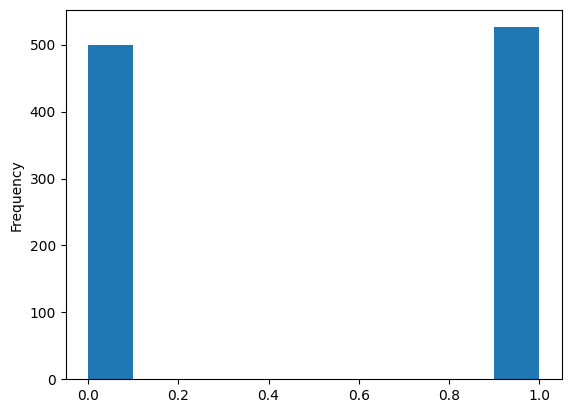

In [4]:
df['target'].plot(kind='hist')
plt.show()

There is almost the same percentage of samples with target zero and one, thus we have a balanced dataframe.
Since there are only two options for the target we can say that we have to deal with a binary classification problem.

Lets see what feature has more "weight" on the target, so we use a correlation matrix to do it:

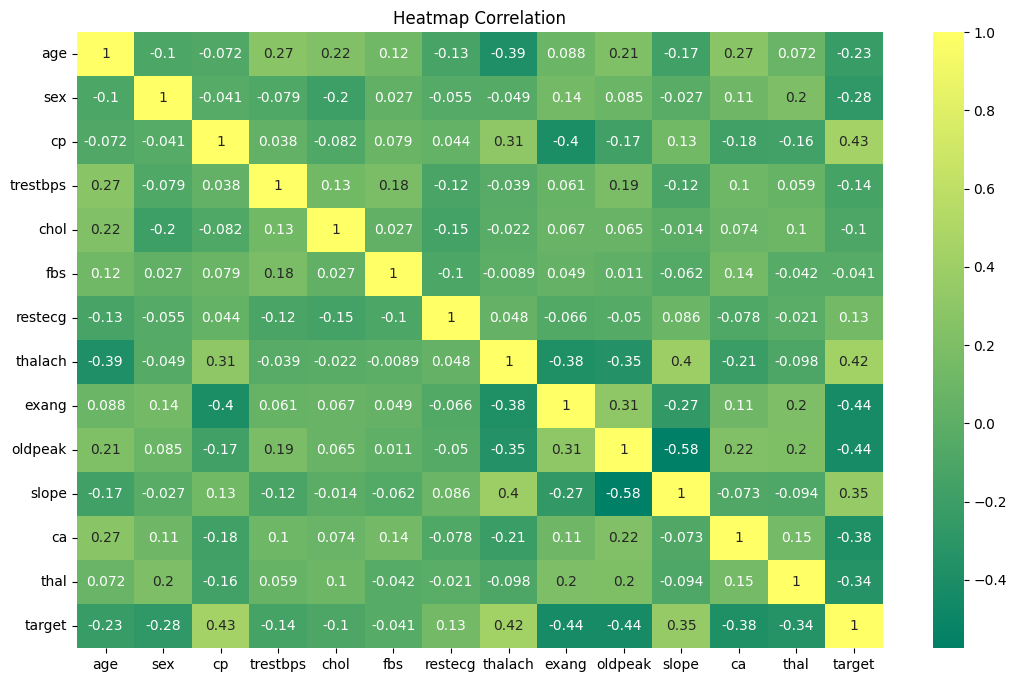

In [34]:
# correlation matrix
plt.figure(figsize = (13,8))
sns.heatmap(df.corr(), annot = True, cmap = 'summer')
plt.title('Heatmap Correlation')
plt.show()

Ok, we can find some direct relation between cp/target, thalach/target and slope/target. It looks weird that age is inversely correlated with target. Let's see this more in detail.

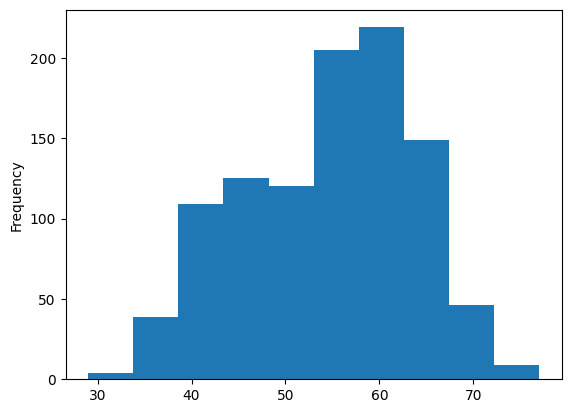

In [6]:
df['age'].plot(kind='hist')
plt.show()

Asymmetric distribution with a peak around 60 years

In [7]:
print('average age:', df['age'].mean().round(1))
print('std deviation:', df['age'].std().round(1))

average age: 54.4
std deviation: 9.1


Lets consider it again but making distinction between target type.

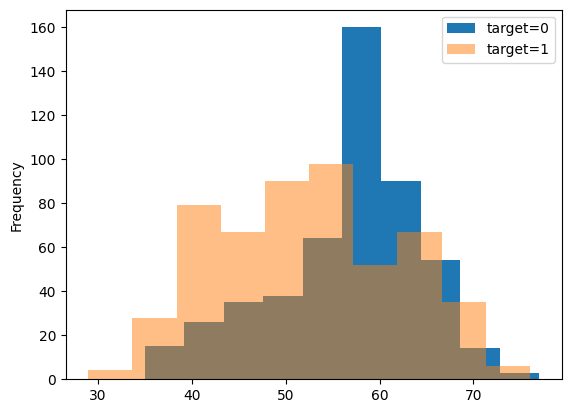

In [8]:
df.loc[df['target']==0, 'age'].plot(kind='hist', label='target=0')
df.loc[df['target']==1, 'age'].plot(kind='hist', label='target=1', alpha=0.5)
plt.legend()
plt.show()

indeed, altough it looks weird, average age of unhealty patiences is lower than healthy ones.

Lets now see another variable well correlated with target: cp

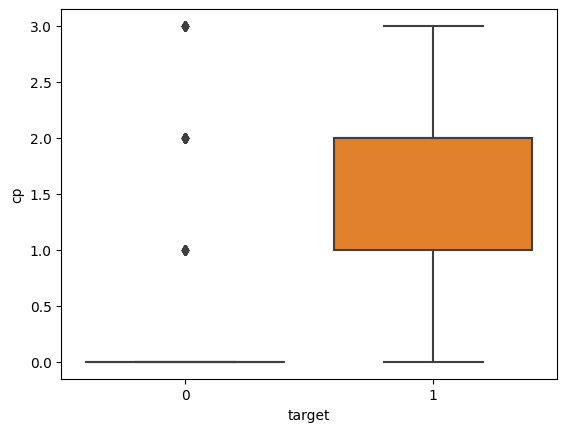

In [9]:
sns.boxplot(data=df, x='target', y='cp')
plt.show()

this last makes much more sense, because when target = 0 (no hearth disease), cp is minimum, so no chest pain, whereas when target = 1, cp is between 1 and 2.

## Stage 2. Data preprocessing <a id='2'></a>

In [36]:
x = df.drop('target', axis=1)
y = df.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12345)

print(x_train.shape)
print(x_test.shape)

(820, 13)
(205, 13)


Since we have all positive values in our dataset, there is no need of standardization. We could use instead MinMaxScale to get all values between 0 and 1.

In [11]:
scaler = MinMaxScaler()

# we train the scaler on training data
x_train_scal = scaler.fit_transform(x_train)

# now we use trained scaler to scale the test data
# (pay attention, i do not use '.fit_transform' but 'transform')
x_test_scal = scaler.transform(x_test)

## Stage 3. Model training <a id='3'></a>

Since we have a small dataset (1000 samples) we start with logistic regression

Lets write a function that we will use often:

In [12]:
def train_evaluate_model(model, verbose=False):
    cv = cross_validate(model, x_train_scal, y_train, return_train_score=True, cv=5)
    train_score = np.mean(cv['train_score'])
    test_score = np.mean(cv['test_score'])
    
    if verbose:
        print('Train score', train_score)
        print('Test score', test_score)
    return train_score, test_score

In [13]:
lreg = LogisticRegression(C=0.5)

train_evaluate_model(lreg)

(0.8432926829268294, 0.8390243902439025)

0.84 train score and 0.83 test score, not bad but we are far from an optimal accuracy level
so let's work on the regularization parameter C

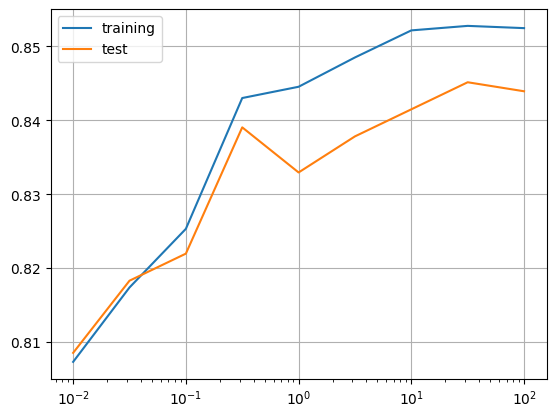

In [14]:
train_scores = []
test_scores = []

C_grid = 10**np.arange(-2, 2.1, 0.5)

for C in C_grid:
    lreg = LogisticRegression(C=C)
    train_score, test_score = train_evaluate_model(lreg)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
plt.plot(C_grid, train_scores, label = 'training')
plt.plot(C_grid, test_scores, label = 'test')
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

parameter C (x-axis) is the inverse of regularization. So, if C is high, there is little regularization and viceversa. in our case, the best C is around 0.5.

To summarize, we are unsatisfied about the performance of the model. So, we use another classifier: Random Forest

we should be well aware that random forest generally memorize the training data and this could invalidate the test.

In [15]:
rf = RandomForestClassifier(random_state=1234)

train_evaluate_model(rf)

(1.0, 0.9829268292682926)

1.00 trains score and 0.98 test score. Very well!
Anyway, lets try to tune some hyperparameter:

In [16]:
distributions = {'n_estimators': np.arange(50, 300, 10),
                'max_depth': np.arange(5, 16, 1),
                'min_samples_leaf': np.arange(1, 6, 1),
                'max_features': np.arange(0.1, 1.1, 0.1)}

In [17]:
search = RandomizedSearchCV(rf, distributions, n_iter=10, cv=5, verbose=2)
# to not wait too much, we use 10 iterations. 
# this will explore 10 combinations applying everytime a cross validation of 5.

search.fit(x_train_scal, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=13, max_features=0.5, min_samples_leaf=1, n_estimators=210; total time=   0.6s
[CV] END max_depth=13, max_features=0.5, min_samples_leaf=1, n_estimators=210; total time=   0.5s
[CV] END max_depth=13, max_features=0.5, min_samples_leaf=1, n_estimators=210; total time=   0.5s
[CV] END max_depth=13, max_features=0.5, min_samples_leaf=1, n_estimators=210; total time=   0.6s
[CV] END max_depth=13, max_features=0.5, min_samples_leaf=1, n_estimators=210; total time=   0.5s
[CV] END max_depth=10, max_features=0.8, min_samples_leaf=4, n_estimators=240; total time=   0.7s
[CV] END max_depth=10, max_features=0.8, min_samples_leaf=4, n_estimators=240; total time=   0.7s
[CV] END max_depth=10, max_features=0.8, min_samples_leaf=4, n_estimators=240; total time=   0.7s
[CV] END max_depth=10, max_features=0.8, min_samples_leaf=4, n_estimators=240; total time=   0.7s
[CV] END max_depth=10, max_features=0.8, min_samples_leaf

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   param_distributions={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5]),
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290])},
                   verbose=2)

In [18]:
# now we see what are the best parameters
best_par = search.best_params_
print(best_par)

{'n_estimators': 210, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 13}


200 estimators, min_samples_leaf=1 means that it stops splitting when there's only one observation in the node, take 50% of the features when splitting and max_depth=13

In [19]:
best_score = search.best_score_
print(best_score)

0.9878048780487804


best score is the same as before ~0.98. Now we are going to use the best params to train a best model:

In [20]:
best_rf = RandomForestClassifier(random_state=1234,
                                n_estimators = best_par['n_estimators'],
                                max_depth = best_par['max_depth'],
                                min_samples_leaf = best_par['min_samples_leaf'],
                                max_features = best_par['max_features'])

best_rf.fit(x_train_scal, y_train)

RandomForestClassifier(max_depth=13, max_features=0.5, n_estimators=210,
                       random_state=1234)

In [21]:
best_rf.score(x_test_scal, y_test)

0.9658536585365853

it is weird but the test score with the best_rf is lower than before

In [23]:
y_pred = best_rf.predict(x_test_scal)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       111
           1       0.96      0.97      0.96        94

    accuracy                           0.97       205
   macro avg       0.97      0.97      0.97       205
weighted avg       0.97      0.97      0.97       205



In [24]:
confusion_matrix(y_test, y_pred)

array([[107,   4],
       [  3,  91]], dtype=int64)

only 7 prediction are wrong (3 false negative and 4 false positive). So, model predicts 3 times zeros when the reality is 1 and 4 times one when the reality is zero

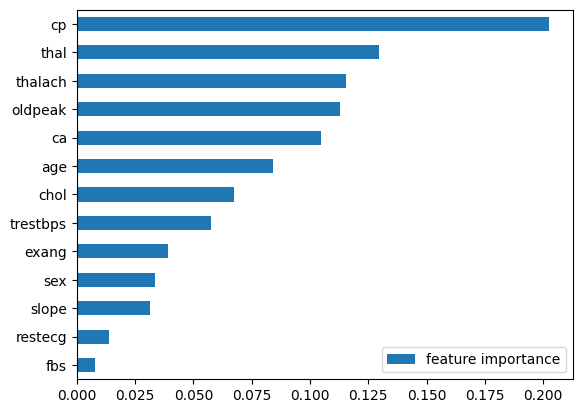

In [26]:
best_rf.feature_importances_


df_features = pd.DataFrame(best_rf.feature_importances_, columns = ['feature importance'])
df_features.index = x.columns

df_features = df_features.sort_values('feature importance')

df_features.plot(kind = 'barh')
plt.show()

This last table is coherent with the correlation matrix we discoverd at the beginning.

## Stage 4. How to use the model <a id='4'></a>

Maybe this model could be used in the future for other data, so lets find a way to make it usable in production. 

Just for the record, many times is thought that the model is only random forest but this is not.
The model instead is all the pipeline that allowed us to start from original data to the end

Lets take for example only the last 10 observations and get the prediction only on those using the best model.

In [45]:
new_data = df.iloc[-10:].drop('target', axis=1)
new_label = df.iloc[-10:, -1]
new_data
new_label

best_rf.predict(new_data)


C:\Users\vidam\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

As we can see, they are not correct. So, to do this in a proper way we should build a pipeline.

In [32]:
# in our case the pipeline is pretty simple, which consists only of two processes.
pipe = Pipeline([('scaler_minmax', scaler),
                ('model', best_rf)])

pipe.predict(new_data)

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0], dtype=int64)

here we can see that the predictions change and this time they are correct.

## Conclusion <a id='conclusion'></a>

So to summarize we explored the data, pre-processed them, made some fit for machine learning algorithm with logistics regression and random forest. We did some hyperparameter tuning and then we explored the results to see some metrics like confusion matrix and feature importance. These are quite important to understand the nature of the problem and which parameters influence the result and in the end we saw how to use the model building a pipeline. In this case it was easy because it has only two elements.